# Variational Autoencoder (VAE) in PyTorch on Fashion-MNIST (latent dim = 2)

This notebook trains a simple VAE **without using labels for training**, then visualizes the learned **2D latent space**.  
For plotting only, we color points by the true Fashion-MNIST category to see whether clusters emerge.

---

## 0) Imports + device

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## 1) Data: Fashion-MNIST

In [2]:
batch_size = 256

transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
])

train_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

Quick peek:

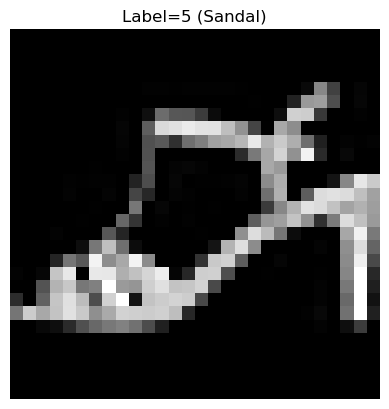

In [3]:
x, y = next(iter(train_loader))
plt.figure()
plt.imshow(x[0].squeeze(), cmap="gray")
plt.title(f"Label={y[0].item()} ({class_names[y[0].item()]})")
plt.axis("off")
plt.show()

## 2) VAE model (MLP encoder/decoder), latent dimension = 2

We flatten each 28×28 image to 784 and use:
- Encoder: 784 → hidden → (mu, logvar) in R^2
- Decoder: 2 → hidden → 784 (Bernoulli logits)

In [4]:
latent_dim = 2
hidden_dim = 400

class VAE(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=400):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(28*28, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 28*28)

    def encode(self, x):
        # x: (B, 1, 28, 28)
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # z = mu + sigma * eps, sigma = exp(0.5*logvar)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_logits(self, z):
        h = F.relu(self.fc2(z))
        logits = self.fc_out(h)
        return logits

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decode_logits(z)
        return logits, mu, logvar

vae = VAE(latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
print(vae)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc_mu): Linear(in_features=400, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=400, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=400, bias=True)
  (fc_out): Linear(in_features=400, out_features=784, bias=True)
)


## 3) Loss: reconstruction + KL (derivation)

A VAE specifies a latent-variable generative model  

$$
p_\theta(x,z)=p(z)\,p_\theta(x\mid z),
\qquad p(z)=\mathcal N(0,I),
$$

and introduces an encoder (variational posterior)

$$
q_\phi(z\mid x)=\mathcal N\!\big(\mu_\phi(x),\operatorname{diag}(\sigma_\phi(x)^2)\big),
$$

where the network outputs $\mu_\phi(x)\in\mathbb R^d$ and $\log\sigma_\phi(x)^2\in\mathbb R^d$ (often called `logvar`).

### Evidence Lower Bound (ELBO)

We want to maximize the marginal log-likelihood

$$
\log p_\theta(x)=\log\int p_\theta(x\mid z)p(z)\,dz,
$$

which is intractable directly. Using Jensen’s inequality on

$$
\log p_\theta(x)
=
\log\int q_\phi(z\mid x)\frac{p_\theta(x\mid z)p(z)}{q_\phi(z\mid x)}\,dz
=
\log \mathbb E_{q_\phi(z\mid x)}
\left[
\frac{p_\theta(x\mid z)p(z)}{q_\phi(z\mid x)}
\right],
$$

we obtain the ELBO:

$$
\log p_\theta(x)\;\ge\;
\mathbb E_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)]
-
\mathrm{KL}\!\left(q_\phi(z\mid x)\,\|\,p(z)\right).
$$

So training a VAE typically **maximizes** the ELBO, or equivalently **minimizes** the negative ELBO:

$$
\mathcal L(x)
=
-
\mathbb E_{q_\phi(z\mid x)}[\log p_\theta(x\mid z)]
+
\mathrm{KL}\!\left(q_\phi(z\mid x)\,\|\,p(z)\right).
$$

---

### Reconstruction term (why BCE-with-logits appears)

For MNIST/Fashion-MNIST it is common to model pixels as conditionally independent Bernoulli given $z$:

$$
p_\theta(x\mid z)
=
\prod_{j=1}^{784}
\operatorname{Bernoulli}\!\left(x_j;\; \pi_j(z)\right),
\qquad
\pi(z)=\sigma(\ell_\theta(z)).
$$

Here $\ell_\theta(z)\in\mathbb R^{784}$ are the decoder **logits** and $\sigma(\cdot)$ is the logistic sigmoid.

Then the conditional log-likelihood is

$$
\log p_\theta(x\mid z)
=
\sum_{j=1}^{784}
\Big[
x_j\log \pi_j(z)
+
(1-x_j)\log(1-\pi_j(z))
\Big].
$$

Negating this gives the binary cross-entropy. Using logits directly is numerically stable, which is exactly what  

`binary_cross_entropy_with_logits(logits, x)` computes:

$$
-\log p_\theta(x\mid z)
=
\mathrm{BCE}\big(x,\sigma(\ell_\theta(z))\big)
=
\mathrm{BCEWithLogits}\big(x,\ell_\theta(z)\big).
$$

In code we approximate the expectation $\mathbb E_{q_\phi(z\mid x)}[\cdot]$ by sampling $z$ once per datapoint (using the reparameterization trick), and we sum over pixels.

---

### KL term (closed form for Gaussians)

With

$$
q_\phi(z\mid x)=\mathcal N(\mu,\operatorname{diag}(\sigma^2)),
\qquad
p(z)=\mathcal N(0,I),
$$

the KL divergence has a closed form:

$$
\mathrm{KL}(q\|p)
=
\frac12
\sum_{k=1}^{d}
\left(
\mu_k^2
+
\sigma_k^2
-
\log\sigma_k^2
-
1
\right).
$$

If we parameterize by  

$$
\log\sigma_k^2 = \mathrm{logvar}_k,
$$

then $\sigma_k^2=\exp(\mathrm{logvar}_k)$ and

$$
\mathrm{KL}(q\|p)
=
-\frac12
\sum_{k=1}^{d}
\left(
1+\mathrm{logvar}_k-\mu_k^2-\exp(\mathrm{logvar}_k)
\right),
$$

which is the common implementation.

---

### Final loss used in training

For a batch, we typically use

$$
\mathcal L_{\text{batch}}
=
\sum_{i=1}^{B}
\left[
\underbrace{\mathrm{BCEWithLogits}\left(x^{(i)},\ell_\theta(z^{(i)})\right)}_{\text{reconstruction}}
+
\underbrace{\mathrm{KL}\!\left(q_\phi(z\mid x^{(i)})\|p(z)\right)}_{\text{regularization}}
\right].
$$

In the notebook code we use `reduction="sum"` so the loss behaves like a true negative log-likelihood (sum over pixels and batch). We then divide by dataset size or batch size only for reporting.

(Variant: $\beta$-VAE uses $\mathrm{BCE} + \beta\,\mathrm{KL}$ to control disentanglement vs reconstruction.)

```python
def vae_loss(logits, x, mu, logvar):
    # reconstruction term: -log p_theta(x|z) under Bernoulli decoder
    x_flat = x.view(x.size(0), -1)
    recon = F.binary_cross_entropy_with_logits(logits, x_flat, reduction="sum")

    # KL term: KL(N(mu, diag(exp(logvar))) || N(0, I))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon + kl, recon, kl
```


In [5]:
def vae_loss(logits, x, mu, logvar):
    # Reconstruction loss (sum over pixels)
    x_flat = x.view(x.size(0), -1)
    recon = F.binary_cross_entropy_with_logits(logits, x_flat, reduction="sum")

    # KL divergence between q(z|x)=N(mu,diag(sigma^2)) and p(z)=N(0,I)
    # KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl, recon, kl

## 4) Train

Tip: With latent_dim=2, reconstructions won’t be perfect, but the latent structure can still be meaningful.

In [6]:
lr = 1e-3
epochs = 15

opt = torch.optim.Adam(vae.parameters(), lr=lr)

def train_epoch(epoch):
    vae.train()
    total, total_recon, total_kl = 0.0, 0.0, 0.0

    for x, _ in train_loader:  # labels not used for training
        x = x.to(device)

        logits, mu, logvar = vae(x)
        loss, recon, kl = vae_loss(logits, x, mu, logvar)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

    n = len(train_ds)
    print(f"Epoch {epoch:02d} | loss={total/n:.4f} recon={total_recon/n:.4f} kl={total_kl/n:.4f}")

for ep in range(1, epochs+1):
    train_epoch(ep)

Epoch 01 | loss=305.4981 recon=298.2074 kl=7.2907
Epoch 02 | loss=277.2623 recon=270.7064 kl=6.5559
Epoch 03 | loss=273.5909 recon=267.1834 kl=6.4075
Epoch 04 | loss=270.9199 recon=264.5376 kl=6.3823
Epoch 05 | loss=268.8579 recon=262.4103 kl=6.4476
Epoch 06 | loss=267.6024 recon=261.0991 kl=6.5033
Epoch 07 | loss=266.5194 recon=260.0179 kl=6.5016
Epoch 08 | loss=265.7412 recon=259.2373 kl=6.5039
Epoch 09 | loss=265.1108 recon=258.6238 kl=6.4870
Epoch 10 | loss=264.6352 recon=258.1517 kl=6.4835
Epoch 11 | loss=264.1105 recon=257.6432 kl=6.4673
Epoch 12 | loss=263.7249 recon=257.2563 kl=6.4686
Epoch 13 | loss=263.4788 recon=257.0090 kl=6.4698
Epoch 14 | loss=263.1218 recon=256.6571 kl=6.4647
Epoch 15 | loss=262.8258 recon=256.3431 kl=6.4827


## 5) Reconstructions (qualitative check)

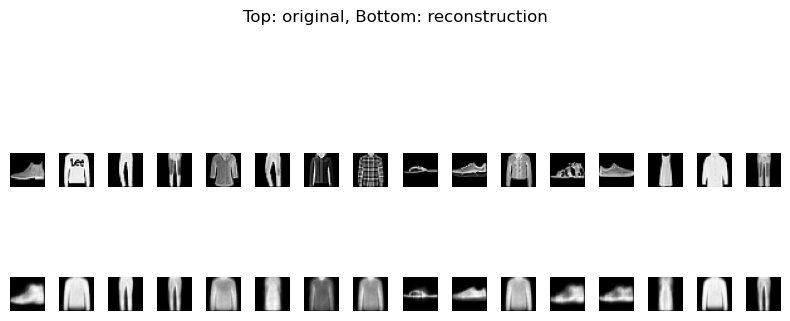

In [7]:
vae.eval()
x, _ = next(iter(test_loader))
x = x.to(device)[:16]

with torch.no_grad():
    logits, _, _ = vae(x)
    xhat = torch.sigmoid(logits).view(-1, 1, 28, 28)

# Plot originals vs reconstructions
plt.figure(figsize=(8, 4))
for i in range(16):
    plt.subplot(2, 16, i+1)
    plt.imshow(x[i].detach().cpu().squeeze(), cmap="gray")
    plt.axis("off")
    plt.subplot(2, 16, 16+i+1)
    plt.imshow(xhat[i].detach().cpu().squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Top: original, Bottom: reconstruction", y=1.02)
plt.tight_layout()
plt.show()

## 6) Latent space embedding plot (colored by labels for visualization only)

We embed each test image as **mu(x)** in R^2 and plot.  
Even though the model never trained on labels, categories often separate into regions.

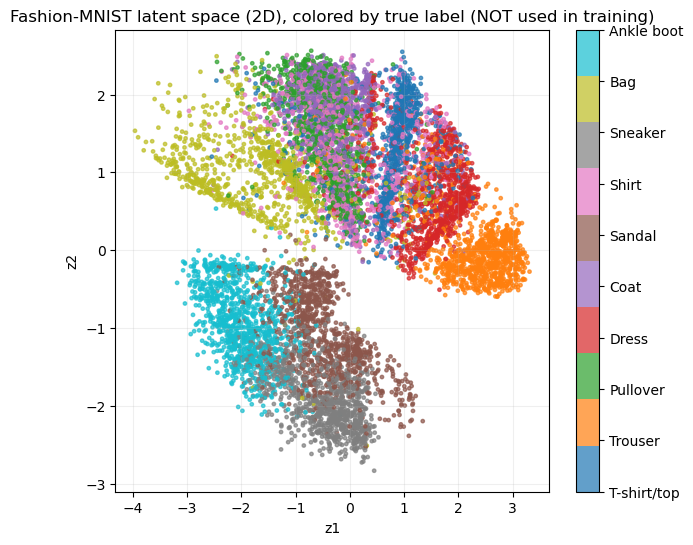

In [8]:
vae.eval()
Z = []
Y = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, logvar = vae.encode(x)
        Z.append(mu.cpu().numpy())  # use mu for a stable embedding
        Y.append(y.numpy())

Z = np.concatenate(Z, axis=0)  # (N, 2)
Y = np.concatenate(Y, axis=0)  # (N,)

plt.figure(figsize=(7, 6))
sc = plt.scatter(Z[:, 0], Z[:, 1], c=Y, s=6, alpha=0.7, cmap="tab10")
cbar = plt.colorbar(sc, ticks=range(10))
cbar.ax.set_yticklabels(class_names)
plt.title("Fashion-MNIST latent space (2D), colored by true label (NOT used in training)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True, alpha=0.2)
plt.show()

Optional: per-class centroids (helps show separation):

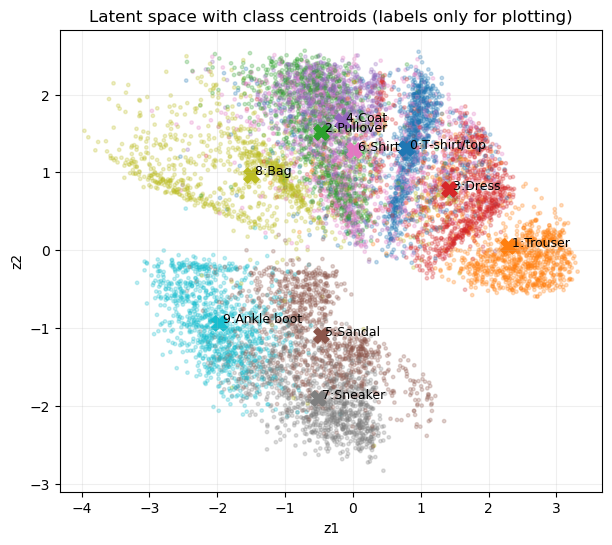

In [9]:
plt.figure(figsize=(7, 6))
plt.scatter(Z[:, 0], Z[:, 1], c=Y, s=6, alpha=0.25, cmap="tab10")

for k in range(10):
    pts = Z[Y == k]
    centroid = pts.mean(axis=0)
    plt.scatter(centroid[0], centroid[1], s=120, marker="X")
    plt.text(centroid[0], centroid[1], f" {k}:{class_names[k]}", fontsize=9)

plt.title("Latent space with class centroids (labels only for plotting)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True, alpha=0.2)
plt.show()

## 7) Sample a 2D grid of latent points and decode (generative “manifold”)

Because z is 2D, we can decode a grid in latent space to see how images morph across it.

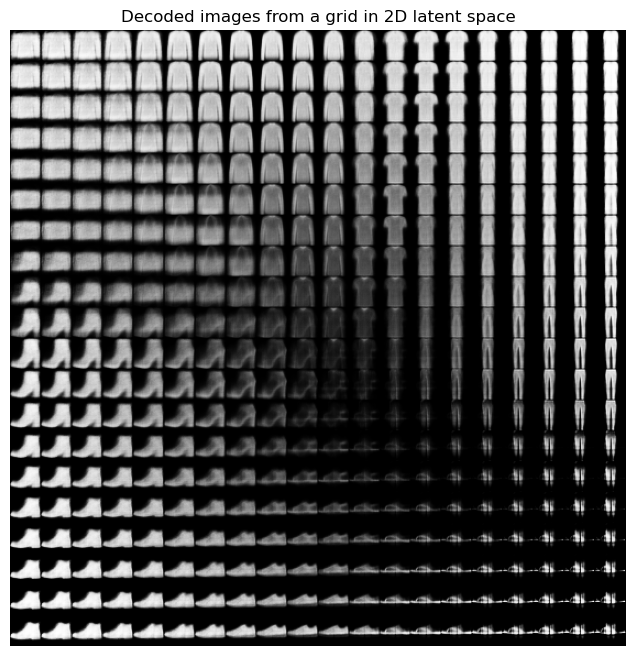

In [10]:
vae.eval()

# Choose grid bounds based on embedded points (mu on test set)
z1_min, z1_max = np.percentile(Z[:, 0], [1, 99])
z2_min, z2_max = np.percentile(Z[:, 1], [1, 99])

n = 20  # grid resolution
z1 = np.linspace(z1_min, z1_max, n)
z2 = np.linspace(z2_min, z2_max, n)

canvas = np.zeros((28*n, 28*n), dtype=np.float32)

with torch.no_grad():
    for i, yi in enumerate(z2[::-1]):     # reverse y for visual "up"
        for j, xj in enumerate(z1):
            z = torch.tensor([[xj, yi]], dtype=torch.float32, device=device)
            logits = vae.decode_logits(z)
            img = torch.sigmoid(logits).view(28, 28).cpu().numpy()
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = img

plt.figure(figsize=(8, 8))
plt.imshow(canvas, cmap="gray")
plt.title("Decoded images from a grid in 2D latent space")
plt.axis("off")
plt.show()

## 8) Notes / tweaks if clusters look weak

- Train longer (e.g., 30–50 epochs).
- Increase hidden_dim (e.g., 600–800) or use a small CNN encoder/decoder.
- Use a KL weight (β-VAE): `loss = recon + beta * kl` with `beta` in `[0.5, 4]`.
- Normalize data and use a Gaussian decoder loss (MSE) instead of BCE.

